In [18]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, classification_report, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import warnings
import os

warnings.filterwarnings('ignore')
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

# Klasyfikacja Ryzyka Cukrzycy

## Autorzy
Filip Obuchowicz, Kamil Pizon

## Streszczenie
Niniejszy projekt ma na celu zbudowanie i porównanie modeli klasyfikacyjnych do przewidywania ryzyka cukrzycy na podstawie danych zdrowotnych i demograficznych. Wykorzystane zostaną dane z badania BRFSS2015. W ramach projektu przeprowadzono wstępną analizę danych, transformacje, identyfikację i obsługę braków danych oraz obserwacji odstających. Zastosowano trzy algorytmy klasyfikacyjne: K-Nearest Neighbors (KNN), Drzewo Decyzyjne oraz Las Losowy (Random Forest), a także model hybrydowy. Modele zostaną ocenione przy użyciu metryk takich jak Accuracy, F1-Score, AUC oraz macierz konfuzji. Przedstawione zostaną również przykłady użycia wytrenowanych modeli na nowych, nieznanych obserwacjach.

## Słowa kluczowe
Cukrzyca, Klasyfikacja, Machine Learning, KNN, Drzewo Decyzyjne, Random Forest, Analiza danych, Walidacja krzyżowa, SMOTE

## Wprowadzenie
Cukrzyca jest poważnym problemem zdrowotnym na całym świecie, prowadzącym do wielu powikłań, takich jak choroby serca, udar, niewydolność nerek czy utrata wzroku. Wczesne wykrycie i interwencja są kluczowe dla zarządzania chorobą i poprawy jakości życia pacjentów. Rozwój modeli predykcyjnych opartych na danych medycznych i behawioralnych może znacząco przyczynić się do identyfikacji osób zagrożonych, umożliwiając wdrożenie działań zapobiegawczych. W tym projekcie skupiamy się na zastosowaniu algorytmów uczenia maszynowego do klasyfikacji ryzyka cukrzycy.

## Przedmiot badania i Cel
**Przedmiot badania:** Zbiór danych 'diabetes_012_health_indicators_BRFSS2015.csv', zawierający dane zdrowotne i demograficzne ankietowanych osób z badania BRFSS (Behavioral Risk Factor Surveillance System) z 2015 roku, z informacją o statusie cukrzycowym (brak cukrzycy, pre-cukrzyca, cukrzyca).\n
Dla uproszczenia problemu klasyfikacji, zmienna docelowa zostanie przekształcona na binarną, gdzie 0 oznacza brak cukrzycy, a 1 oznacza pre-cukrzycę lub cukrzycę. Pozostałe zmienne to wskaźniki zdrowotne i demograficzne. Poniżej przedstawiono listę zmiennych objaśniających.\n
**Cel:** Głównym celem projektu jest opracowanie i ocena modeli klasyfikacyjnych, które będą w stanie skutecznie przewidywać ryzyko wystąpienia cukrzycy (lub jej braku) na podstawie dostępnych zmiennych. Dodatkowo, projekt ma na celu porównanie wydajności różnych algorytmów uczenia maszynowego oraz zrozumienie, które zmienne mają największy wpływ na predykcję ryzyka cukrzycy.

## Wstępna analiza danych

### Opis danych i zmiennych
Wykorzystany zbiór danych `diabetes_012_health_indicators_BRFSS2015.csv` pochodzi z badania BRFSS 2015, zbierającego dane dotyczące zdrowia dorosłych Amerykanów. Zawiera on 22 zmienne, w tym zmienną docelową `Diabetes_012`, która klasyfikuje status cukrzycowy:\n
- 0: brak cukrzycy\n
- 1: pre-cukrzyca\n
- 2: cukrzyca\n
Dla uproszczenia problemu klasyfikacji, zmienna docelowa zostanie przekształcona na binarną, gdzie 0 oznacza brak cukrzycy, a 1 oznacza pre-cukrzycę lub cukrzycę. Pozostałe zmienne to wskaźniki zdrowotne i demograficzne. Poniżej przedstawiono listę zmiennych objaśniających:

In [19]:
# Wczytanie danych
df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")

# Przekształcenie zmiennej docelowej na binarną
df['Diabetes_012'] = df['Diabetes_012'].replace({1: 1, 2: 1})

print("Zmienna docelowa:", "Diabetes_012")
print("Zmienne objaśniające:", list(df.columns.difference(['Diabetes_012'])))
print("\nKształt zbioru danych:", df.shape)

Zmienna docelowa: Diabetes_012
Zmienne objaśniające: ['Age', 'AnyHealthcare', 'BMI', 'CholCheck', 'DiffWalk', 'Education', 'Fruits', 'GenHlth', 'HeartDiseaseorAttack', 'HighBP', 'HighChol', 'HvyAlcoholConsump', 'Income', 'MentHlth', 'NoDocbcCost', 'PhysActivity', 'PhysHlth', 'Sex', 'Smoker', 'Stroke', 'Veggies']

Kształt zbioru danych: (253680, 22)


### Statystyki opisowe
Poniżej przedstawiono statystyki opisowe dla każdej zmiennej, w tym średnią, medianę (50% kwantyl), minimum, maksimum, odchylenie standardowe oraz skośność. Skośność wskazuje na asymetrię rozkładu danych; wartości bliskie 0 oznaczają rozkład symetryczny, wartości dodatnie skośność prawostronną, a ujemne lewostronną.

In [20]:
desc = df.describe().T
desc["skewness"] = df.skew()
print(desc[["mean", "50%", "min", "max", "std", "skewness"]])

                           mean   50%   min   max       std  skewness
Diabetes_012           0.157588   0.0   0.0   1.0  0.364355  1.879563
HighBP                 0.429001   0.0   0.0   1.0  0.494934  0.286904
HighChol               0.424121   0.0   0.0   1.0  0.494210  0.307075
CholCheck              0.962670   1.0   0.0   1.0  0.189571 -4.881271
BMI                   28.382364  27.0  12.0  98.0  6.608694  2.122004
Smoker                 0.443169   0.0   0.0   1.0  0.496761  0.228810
Stroke                 0.040571   0.0   0.0   1.0  0.197294  4.657340
HeartDiseaseorAttack   0.094186   0.0   0.0   1.0  0.292087  2.778742
PhysActivity           0.756544   1.0   0.0   1.0  0.429169 -1.195546
Fruits                 0.634256   1.0   0.0   1.0  0.481639 -0.557500
Veggies                0.811420   1.0   0.0   1.0  0.391175 -1.592239
HvyAlcoholConsump      0.056197   0.0   0.0   1.0  0.230302  3.854132
AnyHealthcare          0.951053   1.0   0.0   1.0  0.215759 -4.181116
NoDocbcCost         

### Podstawowa wizualizacja danych (Histogramy i Boxploty)
Wizualizacje pomagają zrozumieć rozkład danych i relacje między zmiennymi. Poniżej przedstawiono rozkład zmiennej docelowej oraz histogramy i boxploty dla wybranych zmiennych, aby zilustrować ich rozkłady i zależności od statusu cukrzycowego.

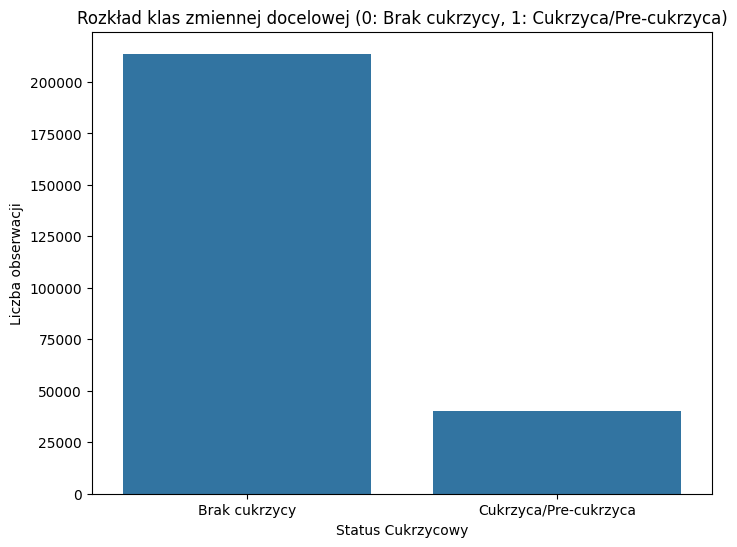

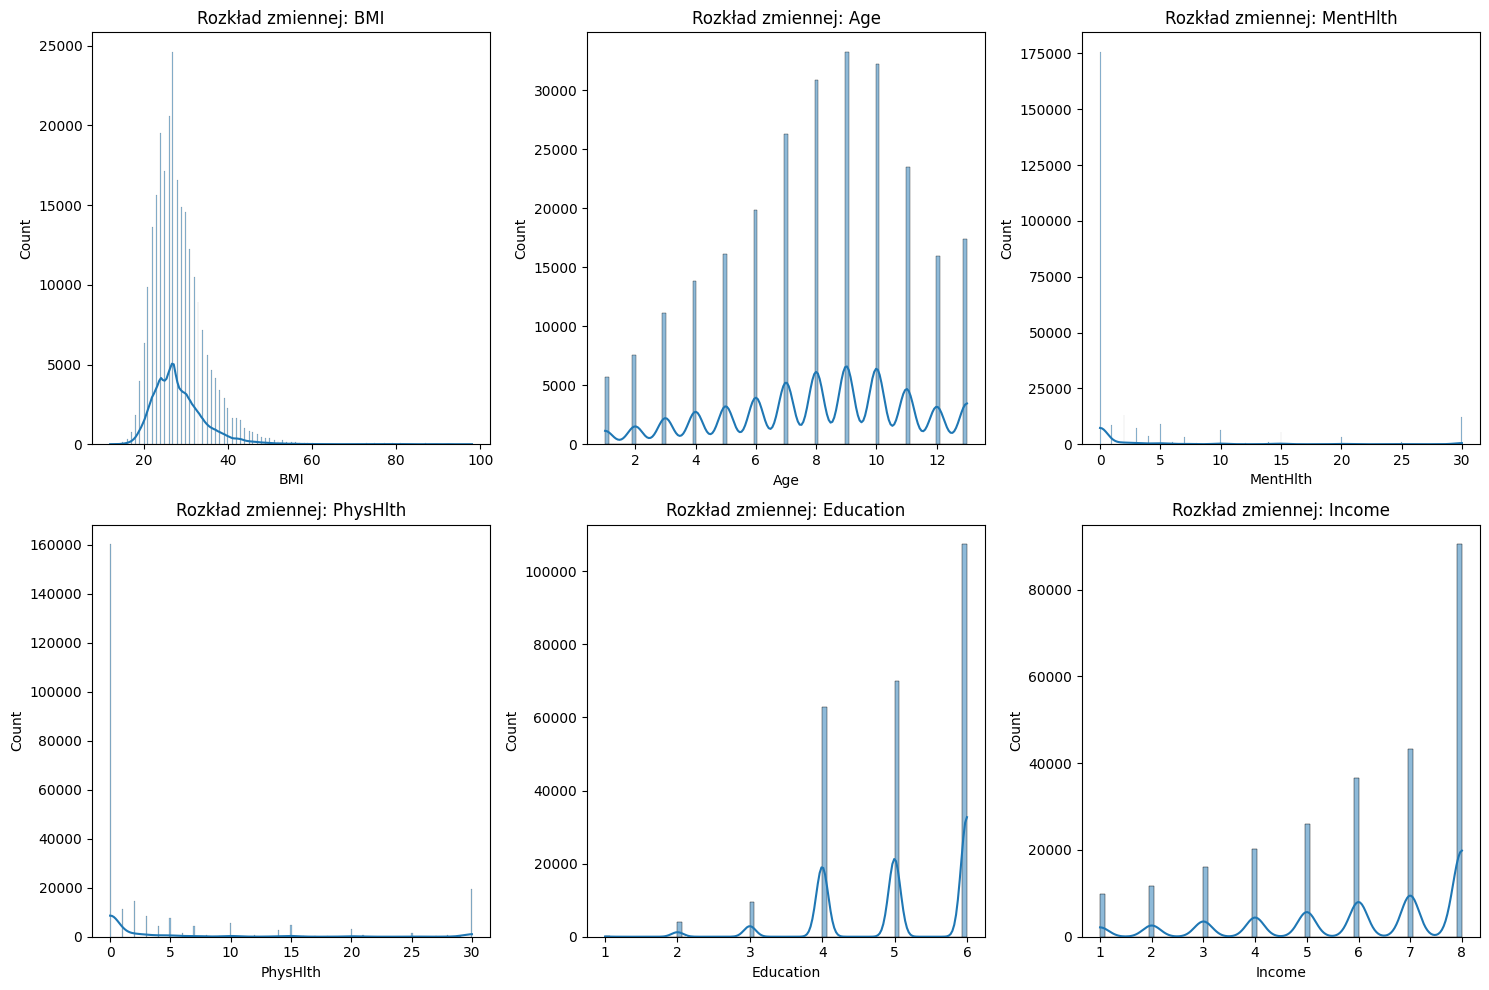

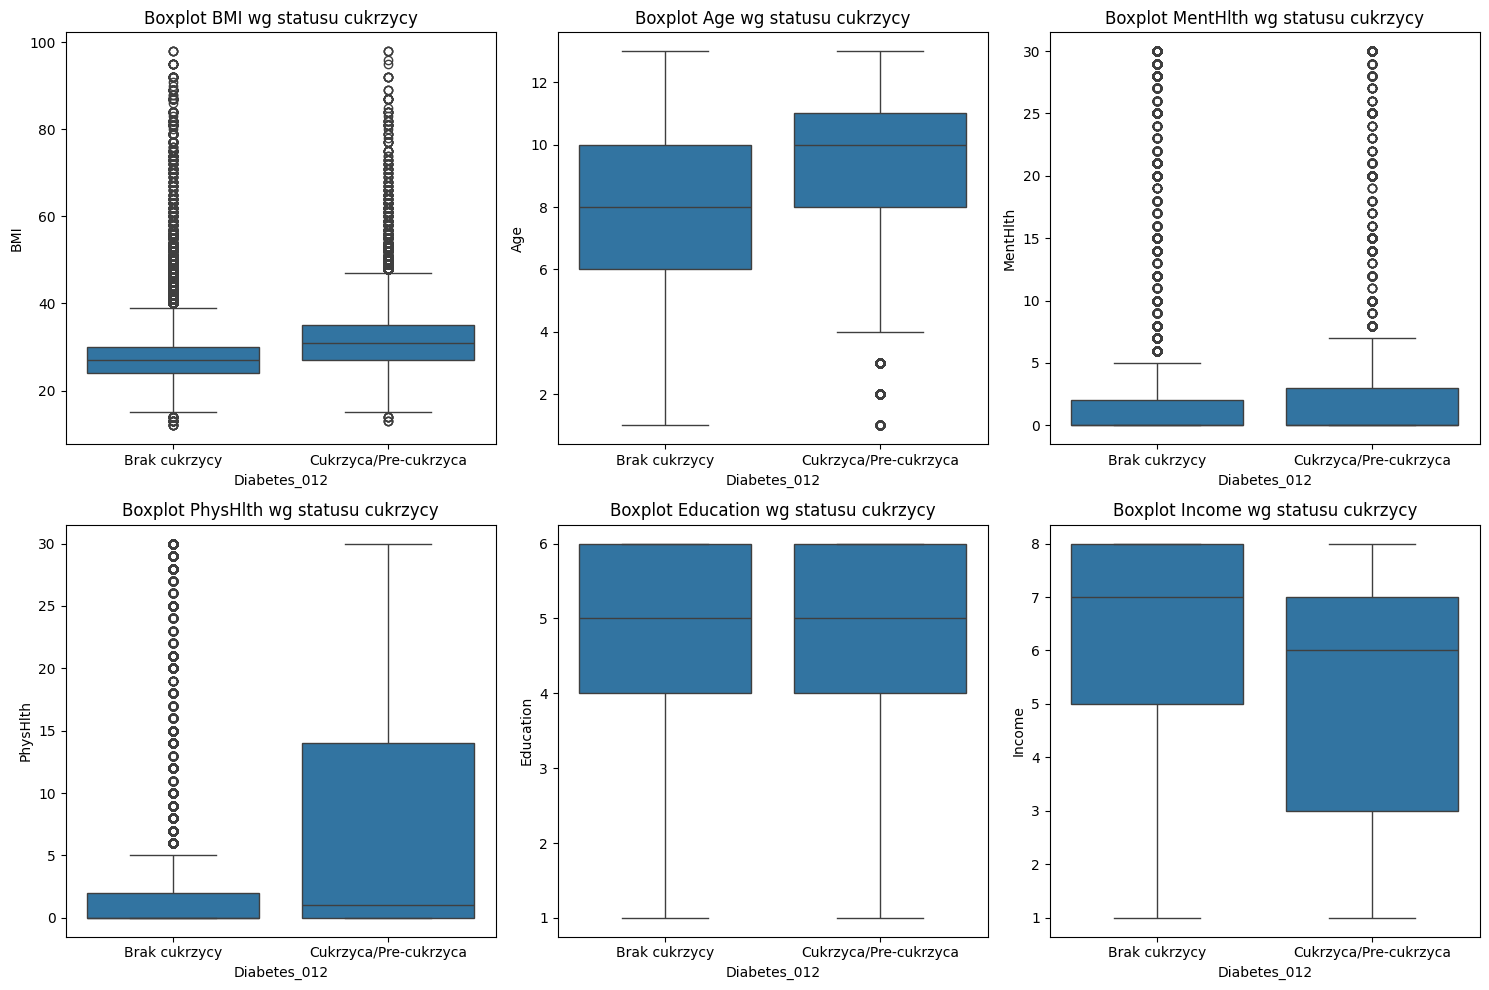

In [21]:
# Rozkład klas zmiennej docelowej
plt.figure(figsize=(8, 6))
sns.countplot(x="Diabetes_012", data=df)
plt.title("Rozkład klas zmiennej docelowej (0: Brak cukrzycy, 1: Cukrzyca/Pre-cukrzyca)")
plt.xlabel("Status Cukrzycowy")
plt.ylabel("Liczba obserwacji")
plt.xticks([0, 1], ['Brak cukrzycy', 'Cukrzyca/Pre-cukrzyca'])
plt.show()

# Histogramy dla wybranych zmiennych numerycznych
num_cols = ['BMI', 'Age', 'MentHlth', 'PhysHlth', 'Education', 'Income']
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Rozkład zmiennej: {col}')
plt.tight_layout()
plt.show()

# Boxploty dla wybranych zmiennych numerycznych w zależności od statusu cukrzycowego
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='Diabetes_012', y=col, data=df)
    plt.title(f'Boxplot {col} wg statusu cukrzycy')
    plt.xticks([0, 1], ['Brak cukrzycy', 'Cukrzyca/Pre-cukrzyca'])
plt.tight_layout()
plt.show()

### Braki danych i obserwacje odstające
Przed przystąpieniem do modelowania kluczowe jest sprawdzenie braków danych i obsługi obserwacji odstających. Brakujące wartości mogą prowadzić do błędnych wyników, a obserwacje odstające mogą zniekształcać modele. \n
\n
**Braki danych:** Sprawdzamy, czy w zbiorze danych występują brakujące wartości. Jeśli tak, w zależności od ich liczby i charakteru, można je uzupełnić (np. średnią, medianą, modą) lub usunąć wiersze/kolumny zawierające braki. W tym zbiorze danych nie ma brakujących wartości, co upraszcza preprocessing.\n
\n
**Obserwacje odstające:** Obserwacje odstające to punkty danych, które znacznie odbiegają od większości danych. Można je identyfikować za pomocą metod statystycznych (np. IQR) lub wizualizacji (np. boxploty). W przypadku wielu zmiennych z potencjalnymi wartościami odstającymi, takimi jak BMI, MentHlth czy PhysHlth, skalowanie danych (np. MinMaxScaler) oraz ewentualne transformacje (np. logarytmowanie) pomagają zmniejszyć ich wpływ na modele, zwłaszcza te wrażliwe na skalę zmiennych (np. KNN).

In [22]:
print("Liczba brakujących wartości w każdej kolumnie:")
print(df.isnull().sum())
print("\nBrak brakujących wartości w zbiorze danych.")

Liczba brakujących wartości w każdej kolumnie:
Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

Brak brakujących wartości w zbiorze danych.


### Transformacje danych (Skalowanie i Logarytmowanie)
**Logarytmowanie:** Zmienne o skośnym rozkładzie (np. `BMI`, `MentHlth`, `PhysHlth`, `Age`, `Education`, `Income`) mogą skorzystać z transformacji logarytmicznej, która pomaga zmniejszyć skośność i sprowadzić rozkład do bardziej zbliżonego do normalnego. Użyto `np.log1p`, która oblicza `log(1+x)`, co jest przydatne, gdy dane zawierają zera.\n
\n
**Skalowanie:** Algorytmy uczenia maszynowego oparte na odległości (np. KNN) są wrażliwe na skalę zmiennych. `MinMaxScaler` skaluje każdą zmienną do zakresu [0, 1], co zapewnia, że żadna zmienna nie dominuje nad innymi ze względu na jej większy zakres wartości.

In [23]:
# Zmienne do logarytmowania (wybrane na podstawie analizy skośności)
log_cols = ['BMI', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
for col in log_cols:
    if col in df.columns:
        df[col] = np.log1p(df[col])
        print(f"Zmienna {col} została zlogarytmowana.")

# Skalowanie danych
scaler = MinMaxScaler()
X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("Dane zostały przeskalowane przy użyciu MinMaxScaler.")

Zmienna BMI została zlogarytmowana.
Zmienna MentHlth została zlogarytmowana.
Zmienna PhysHlth została zlogarytmowana.
Zmienna Age została zlogarytmowana.
Zmienna Education została zlogarytmowana.
Zmienna Income została zlogarytmowana.
Dane zostały przeskalowane przy użyciu MinMaxScaler.


### Macierz korelacji zmiennych
Macierz korelacji pokazuje siłę i kierunek liniowych zależności między parami zmiennych. Wysoka korelacja między zmiennymi objaśniającymi (multicollinearity) może wpływać na stabilność i interpretowalność niektórych modeli. Dodatkowo, korelacja zmiennych objaśniających ze zmienną docelową wskazuje na ich potencjalną ważność w przewidywaniu.

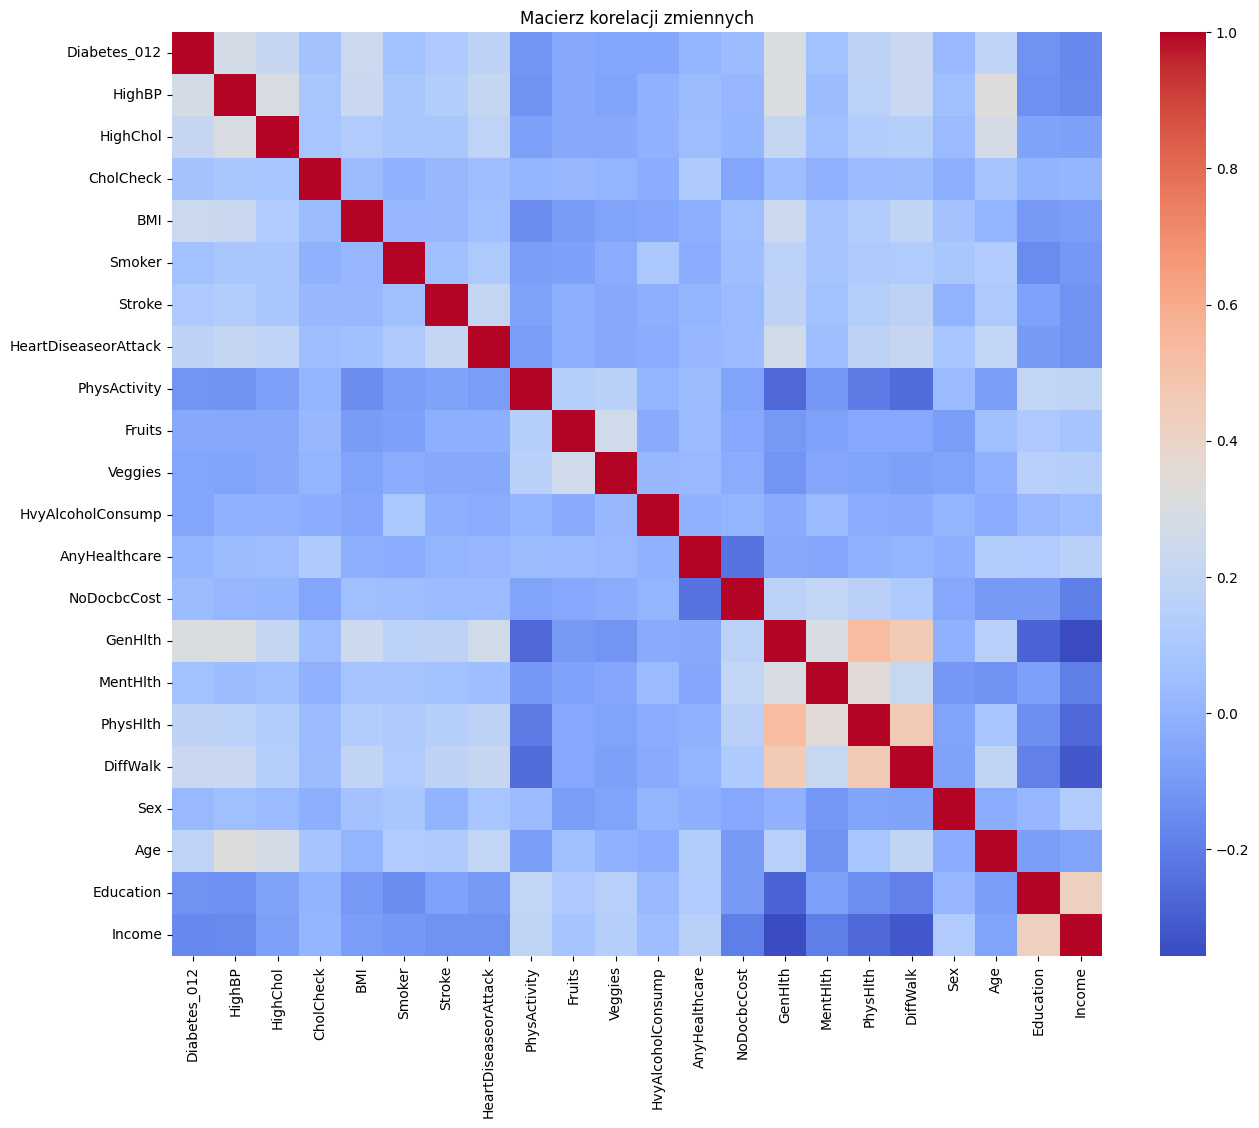

In [24]:
plt.figure(figsize=(15, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Macierz korelacji zmiennych")
plt.show()

## Opis metod

### Podział danych (Treningowe/Testowe)
Zbiór danych został podzielony na podzbiór treningowy (80%) i testowy (20%). Podzbiór treningowy jest używany do uczenia modeli, natomiast podzbiór testowy służy do oceny wydajności wytrenowanych modeli na niewidzianych danych, co pozwala oszacować ich zdolność do generalizacji. Zastosowano `stratify=y` aby zachować proporcje klas zmiennej docelowej w obu podzbiorach, co jest kluczowe w przypadku niezbalansowanych klas.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print("Kształt zbioru treningowego X:", X_train.shape)
print("Kształt zbioru testowego X:", X_test.shape)
print("Kształt zbioru treningowego y:", y_train.shape)
print("Kształt zbioru testowego y:", y_test.shape)

Kształt zbioru treningowego X: (202944, 21)
Kształt zbioru testowego X: (50736, 21)
Kształt zbioru treningowego y: (202944,)
Kształt zbioru testowego y: (50736,)


### Obsługa niezbalansowanych danych - SMOTE
Zauważono, że klasy w zmiennej docelowej są niezbalansowane (znacznie więcej obserwacji bez cukrzycy niż z cukrzycą). Niezbalansowane klasy mogą prowadzić do modeli, które są biasowe w stronę klasy większościowej i słabo radzą sobie z przewidywaniem klasy mniejszościowej. Aby temu zaradzić, zastosowano metodę **SMOTE (Synthetic Minority Over-sampling Technique)** na zbiorze treningowym. SMOTE tworzy syntetyczne próbki klasy mniejszościowej na podstawie istniejących próbek, co pomaga wyrównać rozkład klas i poprawić wydajność modelu dla klasy mniejszościowej.

In [26]:
print("Rozkład klas przed SMOTE:")
print(y_train.value_counts())

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("\nRozkład klas po SMOTE:")
print(y_train_res.value_counts())

Rozkład klas przed SMOTE:
Diabetes_012
0.0    170962
1.0     31982
Name: count, dtype: int64

Rozkład klas po SMOTE:
Diabetes_012
1.0    170962
0.0    170962
Name: count, dtype: int64


### Modele Klasyfikacyjne

#### K-Nearest Neighbors (KNN)
**Opis:** KNN to algorytm klasyfikacyjny oparty na odległości. Klasyfikuje nową obserwację na podstawie większości głosów jej 'k' najbliższych sąsiadów w przestrzeni cech. Działa na zasadzie 'leniwego uczenia' (lazy learning), co oznacza, że nie buduje modelu podczas fazy treningowej, a jedynie przechowuje dane treningowe i wykonuje obliczenia dopiero w momencie predykcji.  Wartość `k` (liczba sąsiadów) jest kluczowym hiperparametrem. \n
**Referencje:** Fix, E., & Hodges, J. L. (1951). *Discriminatory Analysis. Nonparametric Discrimination: Consistency Properties.* USAF School of Aviation Medicine, Randolph Field, Texas.  (Choć formalnie praca jest z 1951, koncepcja KNN była rozwijana w latach 60. i 70. przez m.in. T. Covera i P. Hart'a).

In [27]:
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train_res, y_train_res)
y_pred_knn = model_knn.predict(X_test)
y_proba_knn = model_knn.predict_proba(X_test)[:, 1]

print("K-Nearest Neighbors (KNN) - Macierz Konfuzji:")
print(confusion_matrix(y_test, y_pred_knn))
print("\nRaport klasyfikacyjny KNN:")
print(classification_report(y_test, y_pred_knn))
print("AUC KNN:", roc_auc_score(y_test, y_proba_knn))
print("Accuracy KNN:", accuracy_score(y_test, y_pred_knn))
print("F1-Score KNN:", f1_score(y_test, y_pred_knn))

K-Nearest Neighbors (KNN) - Macierz Konfuzji:
[[31013 11728]
 [ 3120  4875]]

Raport klasyfikacyjny KNN:
              precision    recall  f1-score   support

         0.0       0.91      0.73      0.81     42741
         1.0       0.29      0.61      0.40      7995

    accuracy                           0.71     50736
   macro avg       0.60      0.67      0.60     50736
weighted avg       0.81      0.71      0.74     50736

AUC KNN: 0.7166376490044117
Accuracy KNN: 0.707347839798171
F1-Score KNN: 0.3963736889177982


#### Drzewo Decyzyjne (Decision Tree)
**Opis:** Drzewo decyzyjne to model klasyfikacyjny, który konstruuje drzewo, gdzie każdy węzeł wewnętrzny reprezentuje test na atrybucie, każda gałąź reprezentuje wynik testu, a każdy liść (węzeł końcowy) reprezentuje etykietę klasy. Proces budowy drzewa polega na rekurencyjnym dzieleniu danych na podgrupy na podstawie cech, które najlepiej rozdzielają klasy. \n
**Referencje:** Quinlan, J. R. (1986). *Induction of decision trees.* Machine learning, 1(1), 81-106.

In [28]:
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train_res, y_train_res)
y_pred_dt = model_dt.predict(X_test)
y_proba_dt = model_dt.predict_proba(X_test)[:, 1]

print("Drzewo Decyzyjne - Macierz Konfuzji:")
print(confusion_matrix(y_test, y_pred_dt))
print("\nRaport klasyfikacyjny Drzewa Decyzyjnego:")
print(classification_report(y_test, y_pred_dt))
print("AUC Drzewa Decyzyjnego:", roc_auc_score(y_test, y_proba_dt))
print("Accuracy Drzewa Decyzyjnego:", accuracy_score(y_test, y_pred_dt))
print("F1-Score Drzewa Decyzyjnego:", f1_score(y_test, y_pred_dt))

Drzewo Decyzyjne - Macierz Konfuzji:
[[36638  6103]
 [ 5184  2811]]

Raport klasyfikacyjny Drzewa Decyzyjnego:
              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87     42741
         1.0       0.32      0.35      0.33      7995

    accuracy                           0.78     50736
   macro avg       0.60      0.60      0.60     50736
weighted avg       0.79      0.78      0.78     50736

AUC Drzewa Decyzyjnego: 0.603499190749395
Accuracy Drzewa Decyzyjnego: 0.7775346893724377
F1-Score Drzewa Decyzyjnego: 0.33248565852504586


#### Wizualizacja Drzewa Klasyfikacji (Przykładowe małe drzewo)
Dla lepszego zrozumienia działania drzewa decyzyjnego, poniżej przedstawiono wizualizację małego drzewa zbudowanego na podzbiorze danych. Pozwala to na podgląd reguł decyzyjnych.

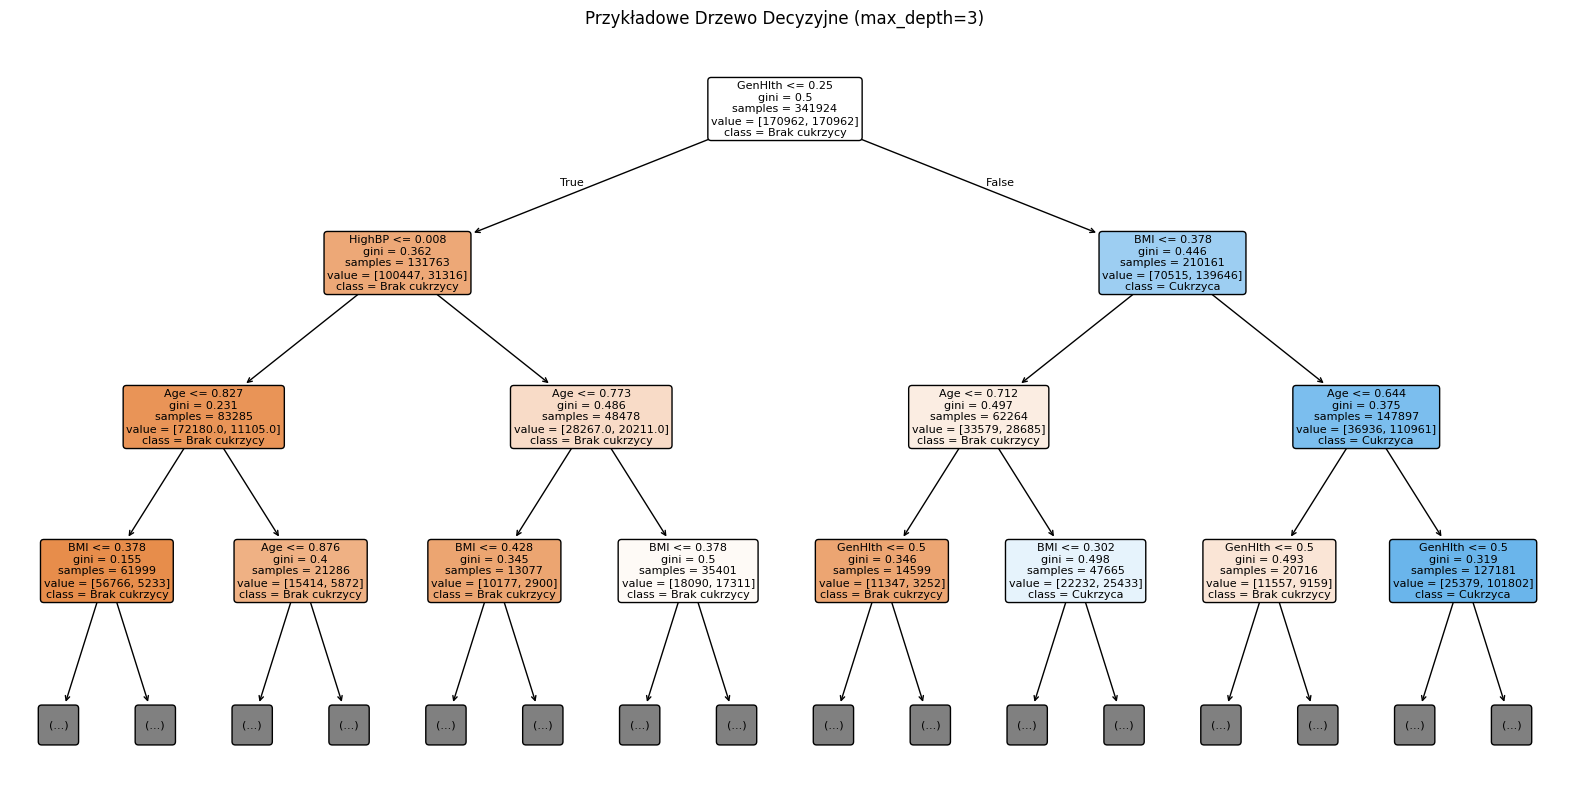

In [29]:
plt.figure(figsize=(20, 10))
plot_tree(model_dt, feature_names=X.columns, class_names=['Brak cukrzycy', 'Cukrzyca'], filled=True, rounded=True, fontsize=8, max_depth=3)
plt.title("Przykładowe Drzewo Decyzyjne (max_depth=3)")
plt.show()

#### Las Losowy (Random Forest)
**Opis:** Random Forest to algorytm zespołowy (ensemble learning), który buduje wiele drzew decyzyjnych podczas treningu i wyprowadza klasę, która jest modą klas (klasyfikacja) lub średnią predykcji (regresja) poszczególnych drzew. Kluczową ideą jest losowe wybieranie podzbiorów cech i podpróbek danych treningowych dla każdego drzewa, co zwiększa różnorodność i redukuje wariancję, prowadząc do lepszej generalizacji. \n
**Referencje:** Breiman, L. (2001). *Random Forests.* Machine Learning, 45(1), 5-32.

In [30]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_res, y_train_res)
y_pred_rf = model_rf.predict(X_test)
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]

print("Random Forest - Macierz Konfuzji:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nRaport klasyfikacyjny Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("AUC Random Forest:", roc_auc_score(y_test, y_proba_rf))
print("Accuracy Random Forest:", accuracy_score(y_test, y_pred_rf))
print("F1-Score Random Forest:", f1_score(y_test, y_pred_rf))

Random Forest - Macierz Konfuzji:
[[39825  2916]
 [ 5502  2493]]

Raport klasyfikacyjny Random Forest:
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90     42741
         1.0       0.46      0.31      0.37      7995

    accuracy                           0.83     50736
   macro avg       0.67      0.62      0.64     50736
weighted avg       0.81      0.83      0.82     50736

AUC Random Forest: 0.792783989326522
Accuracy Random Forest: 0.8340823084200568
F1-Score Random Forest: 0.3719785138764548


#### Model Hybrydowy (Ensemble - Średnia Ważona Prawdopodobieństw)
**Opis:** Model hybrydowy łączy predykcje z wielu modeli bazowych w celu uzyskania lepszej ogólnej wydajności niż pojedynczy model. W tym przypadku zastosowano proste uśrednianie prawdopodobieństw przewidywanych przez każdy z trzech modeli (KNN, Drzewo Decyzyjne, Random Forest). Można również zastosować średnią ważoną, jeśli z eksperymentów wynika, że niektóre modele są bardziej wiarygodne. Klasyfikacja odbywa się poprzez zaokrąglenie średniego prawdopodobieństwa do najbliższej liczby całkowitej (0 lub 1). \n
**Referencje:** Rokach, L. (2010). *Ensemble-based classifiers*. The Data Mining and Knowledge Discovery Handbook, 193-219. (Ogólna koncepcja modeli zespołowych).

In [31]:
# Przewidywanie prawdopodobieństw dla wszystkich modeli
y_proba_knn = model_knn.predict_proba(X_test)[:, 1]
y_proba_dt = model_dt.predict_proba(X_test)[:, 1]
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]

# Stworzenie modelu hybrydowego (uśrednienie prawdopodobieństw)
y_proba_hybrid = (y_proba_knn + y_proba_dt + y_proba_rf) / 3
y_pred_hybrid = (y_proba_hybrid > 0.5).astype(int)

print("Model Hybrydowy - Macierz Konfuzji:")
print(confusion_matrix(y_test, y_pred_hybrid))
print("\nRaport klasyfikacyjny Modelu Hybrydowego:")
print(classification_report(y_test, y_pred_hybrid))
print("AUC Modelu Hybrydowego:", roc_auc_score(y_test, y_proba_hybrid))
print("Accuracy Modelu Hybrydowego:", accuracy_score(y_test, y_pred_hybrid))
print("F1-Score Modelu Hybrydowego:", f1_score(y_test, y_pred_hybrid))

Model Hybrydowy - Macierz Konfuzji:
[[37720  5021]
 [ 4971  3024]]

Raport klasyfikacyjny Modelu Hybrydowego:
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88     42741
         1.0       0.38      0.38      0.38      7995

    accuracy                           0.80     50736
   macro avg       0.63      0.63      0.63     50736
weighted avg       0.80      0.80      0.80     50736

AUC Modelu Hybrydowego: 0.7661640040549078
Accuracy Modelu Hybrydowego: 0.8030589719331441
F1-Score Modelu Hybrydowego: 0.3770573566084788


### Ważność zmiennych (Feature Importance)
Analiza ważności zmiennych pozwala zidentyfikować, które cechy mają największy wpływ na predykcję modelu. Jest to szczególnie przydatne w przypadku modeli opartych na drzewach, takich jak Random Forest, które naturalnie dostarczają informacji o ważności cech. Poniżej przedstawiono tabelę z ważnością zmiennych dla modelu Random Forest.

Tabela z ważnością zmiennych (Random Forest):
                 Feature  Importance
3                    BMI    0.192859
18                   Age    0.161438
13               GenHlth    0.145395
20                Income    0.106272
19             Education    0.083034
0                 HighBP    0.060180
15              PhysHlth    0.047013
14              MentHlth    0.034801
1               HighChol    0.029240
16              DiffWalk    0.018334
4                 Smoker    0.016987
8                 Fruits    0.016866
17                   Sex    0.016165
7           PhysActivity    0.014992
9                Veggies    0.013394
6   HeartDiseaseorAttack    0.012044
12           NoDocbcCost    0.007322
10     HvyAlcoholConsump    0.006669
5                 Stroke    0.006541
2              CholCheck    0.005797
11         AnyHealthcare    0.004656


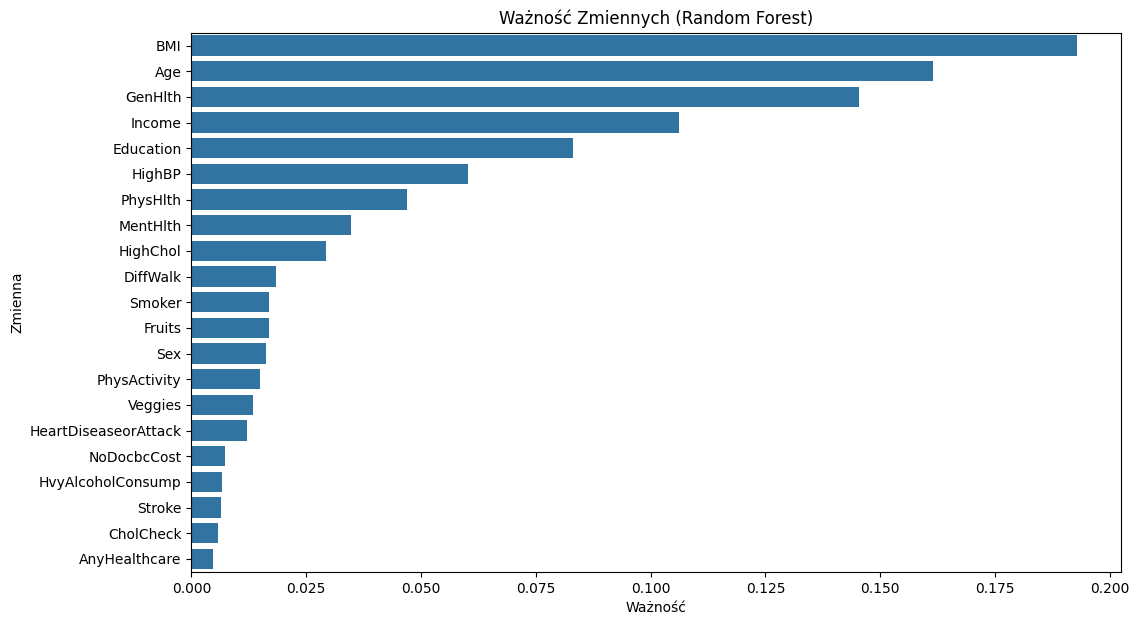

In [32]:
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model_rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("Tabela z ważnością zmiennych (Random Forest):")
print(feature_importances)

plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Ważność Zmiennych (Random Forest)')
plt.xlabel('Ważność')
plt.ylabel('Zmienna')
plt.show()

## Rezultaty

### Porównanie metryk modeli
Poniżej przedstawiono podsumowanie kluczowych metryk (Accuracy, F1-Score, AUC) dla wszystkich wytrenowanych modeli. Pozwala to na bezpośrednie porównanie ich wydajności.

Podsumowanie wydajności modeli:
               Accuracy  F1-Score       AUC
Model                                      
KNN            0.707348  0.396374  0.716638
Decision Tree  0.777535  0.332486  0.603499
Random Forest  0.834082  0.371979  0.792784
Hybrid Model   0.803059  0.377057  0.766164


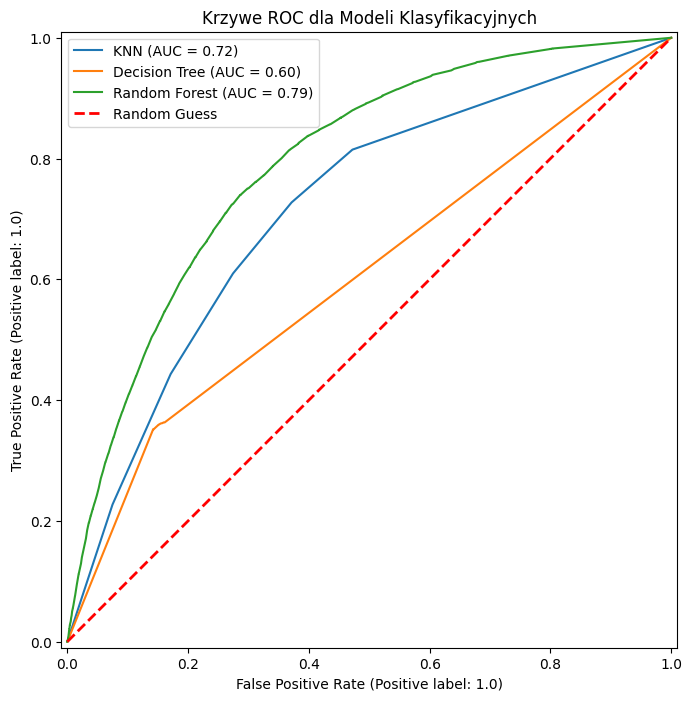

In [33]:
results = pd.DataFrame({
    'Model': ['KNN', 'Decision Tree', 'Random Forest', 'Hybrid Model'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_hybrid)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_knn),
        f1_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_hybrid)
    ],
    'AUC': [
        roc_auc_score(y_test, y_proba_knn),
        roc_auc_score(y_test, y_proba_dt),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_hybrid)
    ]
})
print("Podsumowanie wydajności modeli:")
print(results.set_index('Model'))

# Wizualizacja ROC Curve dla wszystkich modeli
plt.figure(figsize=(10, 8))
ax = plt.gca()
RocCurveDisplay.from_estimator(model_knn, X_test, y_test, ax=ax, name='KNN')
RocCurveDisplay.from_estimator(model_dt, X_test, y_test, ax=ax, name='Decision Tree')
RocCurveDisplay.from_estimator(model_rf, X_test, y_test, ax=ax, name='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guess')
plt.title('Krzywe ROC dla Modeli Klasyfikacyjnych')
plt.legend()
plt.show()

### Sposób walidacji (Walidacja Krzyżowa - Cross-Validation)
Walidacja krzyżowa, w szczególności k-krotna walidacja krzyżowa (k-fold cross-validation), jest robustną metodą oceny wydajności modelu i pomaga uniknąć przeuczenia (overfittingu). Zbiór danych jest dzielony na 'k' podzbiorów. Model jest trenowany 'k' razy, za każdym razem używając innego podzbioru jako zbioru walidacyjnego, a pozostałe 'k-1' podzbiorów jako zbioru treningowego. Wyniki są następnie uśredniane. W ten sposób ocena modelu jest mniej zależna od konkretnego podziału danych na zbiór treningowy i testowy.

In [34]:
print("Wyniki walidacji krzyżowej (5-krotna) - Accuracy:")
cv_scores_knn = cross_val_score(model_knn, X_scaled, y, cv=5, scoring='accuracy', n_jobs=-1)
print(f"KNN: {cv_scores_knn.mean():.4f} (+/- {cv_scores_knn.std():.4f})")

cv_scores_dt = cross_val_score(model_dt, X_scaled, y, cv=5, scoring='accuracy', n_jobs=-1)
print(f"Decision Tree: {cv_scores_dt.mean():.4f} (+/- {cv_scores_dt.std():.4f})")

cv_scores_rf = cross_val_score(model_rf, X_scaled, y, cv=5, scoring='accuracy', n_jobs=-1)
print(f"Random Forest: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})")

# Dla modelu hybrydowego walidacja krzyżowa jest bardziej złożona, wymaga niestandardowej funkcji lub iteracji
# Poniżej przykład prostej walidacji krzyżowej dla hybrydy, jednak dla pełnej oceny zaleca się bardziej zaawansowane podejście ensemble learning cross-validation.
kf = KFold(n_splits=5, shuffle=True, random_state=42)
hybrid_cv_scores = []
for train_index, val_index in kf.split(X_scaled):
    X_train_fold, X_val_fold = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Zastosowanie SMOTE na danych treningowych w każdej fałdzie
    X_train_res_fold, y_train_res_fold = sm.fit_resample(X_train_fold, y_train_fold)

    model_knn.fit(X_train_res_fold, y_train_res_fold)
    model_dt.fit(X_train_res_fold, y_train_res_fold)
    model_rf.fit(X_train_res_fold, y_train_res_fold)

    y_proba_knn_fold = model_knn.predict_proba(X_val_fold)[:, 1]
    y_proba_dt_fold = model_dt.predict_proba(X_val_fold)[:, 1]
    y_proba_rf_fold = model_rf.predict_proba(X_val_fold)[:, 1]

    y_proba_hybrid_fold = (y_proba_knn_fold + y_proba_dt_fold + y_proba_rf_fold) / 3
    y_pred_hybrid_fold = (y_proba_hybrid_fold > 0.5).astype(int)
    hybrid_cv_scores.append(accuracy_score(y_val_fold, y_pred_hybrid_fold))

hybrid_cv_scores = np.array(hybrid_cv_scores)
print(f"Hybrid Model: {hybrid_cv_scores.mean():.4f} (+/- {hybrid_cv_scores.std():.4f})")

Wyniki walidacji krzyżowej (5-krotna) - Accuracy:
KNN: 0.8272 (+/- 0.0020)
Decision Tree: 0.7792 (+/- 0.0029)
Random Forest: 0.8431 (+/- 0.0017)


KeyboardInterrupt: 

## Przykłady użycia modeli na nieznanych obserwacjach
Poniżej przedstawiono przykłady predykcji dla dwóch sztucznie stworzonych obserwacji: jednej reprezentującej osobę zdrową o niskim ryzyku cukrzycy, a drugiej osobę z czynnikami ryzyka. Dane wejściowe są najpierw logarytmowane (dla wybranych zmiennych), a następnie skalowane przy użyciu tego samego `MinMaxScaler`, który został dopasowany do danych treningowych. Dzięki temu, modele mogą dokonywać predykcji na danych o podobnym zakresie i rozkładzie.

In [ ]:
print("=== Dane wejściowe dla osoby zdrowej ===")
sample_healthy = pd.DataFrame([{
    'HighBP': 0, 'HighChol': 0, 'CholCheck': 1, 'BMI': 22, 'Smoker': 0, 'Stroke': 0,
    'HeartDiseaseorAttack': 0, 'PhysActivity': 1, 'Fruits': 1, 'Veggies': 1,
    'HvyAlcoholConsump': 0, 'AnyHealthcare': 1, 'NoDocbcCost': 0, 'GenHlth': 2,
    'MentHlth': 0, 'PhysHlth': 0, 'DiffWalk': 0, 'Sex': 0, 'Age': 6, 'Education': 6, 'Income': 8
}], columns=X.columns) # Ważne aby kolumny zgadzały się z X.columns

print("Nieprzetworzone dane:")
for col, val in sample_healthy.iloc[0].items():
    print(f"{col}: {np.round(val, 3)}")

sample_healthy_processed = sample_healthy.copy()
for col in log_cols:
    if col in sample_healthy_processed.columns:
        sample_healthy_processed[col] = np.log1p(sample_healthy_processed[col])

sample_healthy_scaled = scaler.transform(sample_healthy_processed)

print("\nPredykcje dla osoby zdrowej:")
print(f"KNN przewiduje: {'Cukrzyca' if model_knn.predict(sample_healthy_scaled)[0] == 1 else 'Brak cukrzycy'}")
print(f"Drzewo Decyzyjne przewiduje: {'Cukrzyca' if model_dt.predict(sample_healthy_scaled)[0] == 1 else 'Brak cukrzycy'}")
print(f"Random Forest przewiduje: {'Cukrzyca' if model_rf.predict(sample_healthy_scaled)[0] == 1 else 'Brak cukrzycy'}")

proba_hybrid_healthy = (model_knn.predict_proba(sample_healthy_scaled)[:, 1] + \
                      model_dt.predict_proba(sample_healthy_scaled)[:, 1] + \
                      model_rf.predict_proba(sample_healthy_scaled)[:, 1]) / 3
print(f"Model Hybrydowy przewiduje: {'Cukrzyca' if (proba_hybrid_healthy > 0.5)[0] else 'Brak cukrzycy'}\n")


print("=== Dane wejściowe dla osoby z ryzykiem cukrzycy ===")
sample_risk = pd.DataFrame([{
    'HighBP': 1, 'HighChol': 1, 'CholCheck': 1, 'BMI': 35, 'Smoker': 1, 'Stroke': 0,
    'HeartDiseaseorAttack': 1, 'PhysActivity': 0, 'Fruits': 0, 'Veggies': 0,
    'HvyAlcoholConsump': 0, 'AnyHealthcare': 1, 'NoDocbcCost': 0, 'GenHlth': 4,
    'MentHlth': 20, 'PhysHlth': 30, 'DiffWalk': 1, 'Sex': 1, 'Age': 9, 'Education': 4, 'Income': 3
}], columns=X.columns)

print("Nieprzetworzone dane:")
for col, val in sample_risk.iloc[0].items():
    print(f"{col}: {np.round(val, 3)}")

sample_risk_processed = sample_risk.copy()
for col in log_cols:
    if col in sample_risk_processed.columns:
        sample_risk_processed[col] = np.log1p(sample_risk_processed[col])

sample_risk_scaled = scaler.transform(sample_risk_processed)

print(f"\nPredykcje dla osoby z ryzykiem:")
print(f"KNN przewiduje: {'Cukrzyca' if model_knn.predict(sample_risk_scaled)[0] == 1 else 'Brak cukrzycy'}")
print(f"Drzewo Decyzyjne przewiduje: {'Cukrzyca' if model_dt.predict(sample_risk_scaled)[0] == 1 else 'Brak cukrzycy'}")
print(f"Random Forest przewiduje: {'Cukrzyca' if model_rf.predict(sample_risk_scaled)[0] == 1 else 'Brak cukrzycy'}")

proba_hybrid_risk = (model_knn.predict_proba(sample_risk_scaled)[:, 1] + \
                   model_dt.predict_proba(sample_risk_scaled)[:, 1] + \
                   model_rf.predict_proba(sample_risk_scaled)[:, 1]) / 3
print(f"Model Hybrydowy przewiduje: {'Cukrzyca' if (proba_hybrid_risk > 0.5)[0] else 'Brak cukrzycy'}")

## Bibliografia
\* Breiman, L. (2001). *Random Forests.* Machine Learning, 45(1), 5-32.\n
\* Fix, E., & Hodges, J. L. (1951). *Discriminatory Analysis. Nonparametric Discrimination: Consistency Properties.* USAF School of Aviation Medicine, Randolph Field, Texas.\n
\* Quinlan, J. R. (1986). *Induction of decision trees.* Machine learning, 1(1), 81-106.\n
\* Rokach, L. (2010). *Ensemble-based classifiers*. The Data Mining and Knowledge Discovery Handbook, 193-219.\n
\* Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). *SMOTE: synthetic minority over-sampling technique*. Journal of artificial intelligence research, 16, 321-357.